In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import read, write
from math import ceil
import os
from IPython.display import Audio

In [39]:
FRAME_SIZE = 1024
curr_dir = os.getcwd() + '/' + 'AudioMNIST/data'
# 100e4 for AudioMNIST data set
# for android tablet
THRESHOLD = 200e6 # must be tuned
FRAME_SETBACK = 10 # number of frames to prepend before first frame with significant energy content above the threshold

NUM_ROWS = int((1024 / 2) + 1)
NUM_COLS = 48 # total number of frames to leave in trimmed audio data

#### Introduction

Voice Activity Detection is important for consistently extracting data for speaker recognition. Many Automatic Speaker Recognition (ASR) models are created with the intent of only being applied on audio segments with speech in them. Currently in the scope of ECE 420, AudioMNIST provided consistent audio segments that have been trimmed to only focus on the portions where the speakers are actually voicing a digit 0-9. The trimming done for this dataset was manual, but for a real-time task, we must figure out how to get an Android tablet to automatically recognize when the speaker is talking in an audio segment and solely extract data from that portion of the audio. VAD is an interesting problem with complex manners of tackling the issue, but for the purposes of ECE420, we will use the simple pitch detection from lab to aid in extracting the spoken segements from audio data. 

Once thing to note with how the number of frames are being determined. For simple pitch detection, we simply create a constant FRAME_SIZE (preferably a power of 2 so that the frame size matches the frame size used for the STFT), and slide this window every FRAME_SIZE samples. Typically for the STFT though, 50% overlap is employed in order to deal with spectral leakage. This means that we must also employ 50% overlap when performing simple pitch detection so that the number of frames in the energy spectrum from the pitch detection match the number of frames from the STFT. By doing so, we are able to easily deduce which frames need to be dropped from the STFT that do not contain voiced data. 

In [40]:
def ece420ProcessFrame(frame, threshold = THRESHOLD):
    isVoiced = 0

    #### YOUR CODE HERE ####
    sum = 0
    for n in range(len(frame)):
        sum += abs(frame[n])**2

    if sum > threshold:
        isVoiced = 1

    # print("sum: {}".format(sum))
    return isVoiced

len of data: 255360
Sampling rate of: 48000
Shape of STFT: (513, 497)
Number of Energy Spectrum Frames: 497
Len f: 513
Len t_stft: 497


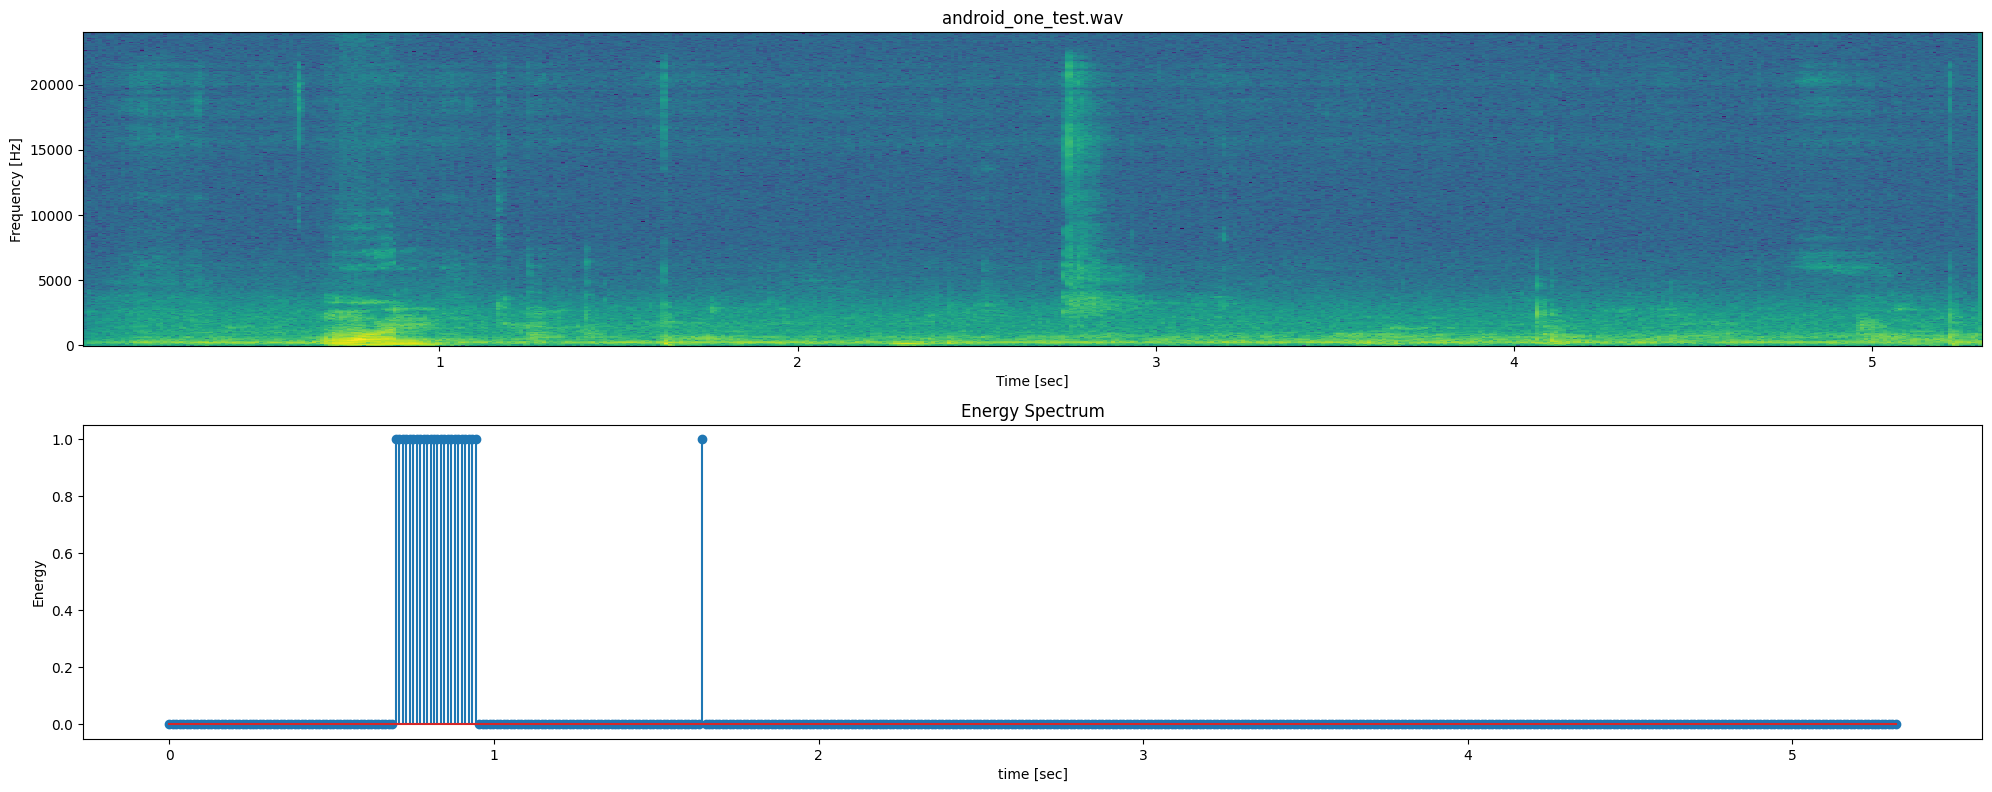

In [41]:
# song_file = '/01/0_01_0.wav'
# song_file = '/30/4_30_0.wav'
song_file = 'android_one_test.wav'
# Fs, data = read(curr_dir + song_file)
Fs, data = read(song_file)
# # TEMP
# data = data[:Fs]
# # END TEMP
num_samples = len(data)
print("len of data: {}".format(num_samples))

noverlap = int(FRAME_SIZE / 2)
step = FRAME_SIZE - noverlap
numFrames = ceil(num_samples / step)
while ((numFrames - 1)*step + (FRAME_SIZE - 1) >= num_samples):
    numFrames -= 1

# numFrames = int(len(data) / FRAME_SIZE)
framesVoiced = np.zeros(numFrames)
t = np.linspace(0, len(data)/Fs, numFrames)

for i in range(numFrames):
    frame = data[i * step : (i + 1) * step]
    framesVoiced[i] = ece420ProcessFrame(frame.astype(float))

print("Sampling rate of: {}".format(Fs))

# conducting a STFT of the data with the same frame size to show a comparision of the visualized sound and its energy spectrum
f, t_stft, result = signal.stft(data, fs=Fs, window='hann', nperseg=FRAME_SIZE, nfft=FRAME_SIZE, noverlap=None, detrend=False, return_onesided=True, boundary=None, padded=False, axis=-1, scaling='psd')
result = 20*np.log10(np.abs(result))

print("Shape of STFT: {}".format(result.shape))
print("Number of Energy Spectrum Frames: {}".format(numFrames))
print("Len f: {}".format(len(f)))
print("Len t_stft: {}".format(len(t_stft)))

fig = plt.figure(figsize=(20,8))
plt.subplot(211)
plt.pcolormesh(t_stft, f, result)
plt.title(song_file)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
# plt.colorbar(format="%+2.f dB") # uncomment to interpret dB content, but leave out for side by side comparison 

plt.subplot(212)
plt.stem(t, framesVoiced)
plt.title("Energy Spectrum")
plt.xlabel("time [sec]")
plt.ylabel("Energy")

fig.tight_layout(pad=1.0)

In [42]:
# Recording of the sound
Audio(data, rate=Fs)

THRESHOLD is a tunable parameter that was set to 200e7 in lab but is instead 100e4 for the AudioMNIST dataset. Now that we have used our simple pitch detection to recognize which frames are voiced, we can attempt to do some trimming to get only the voiced segment.

65


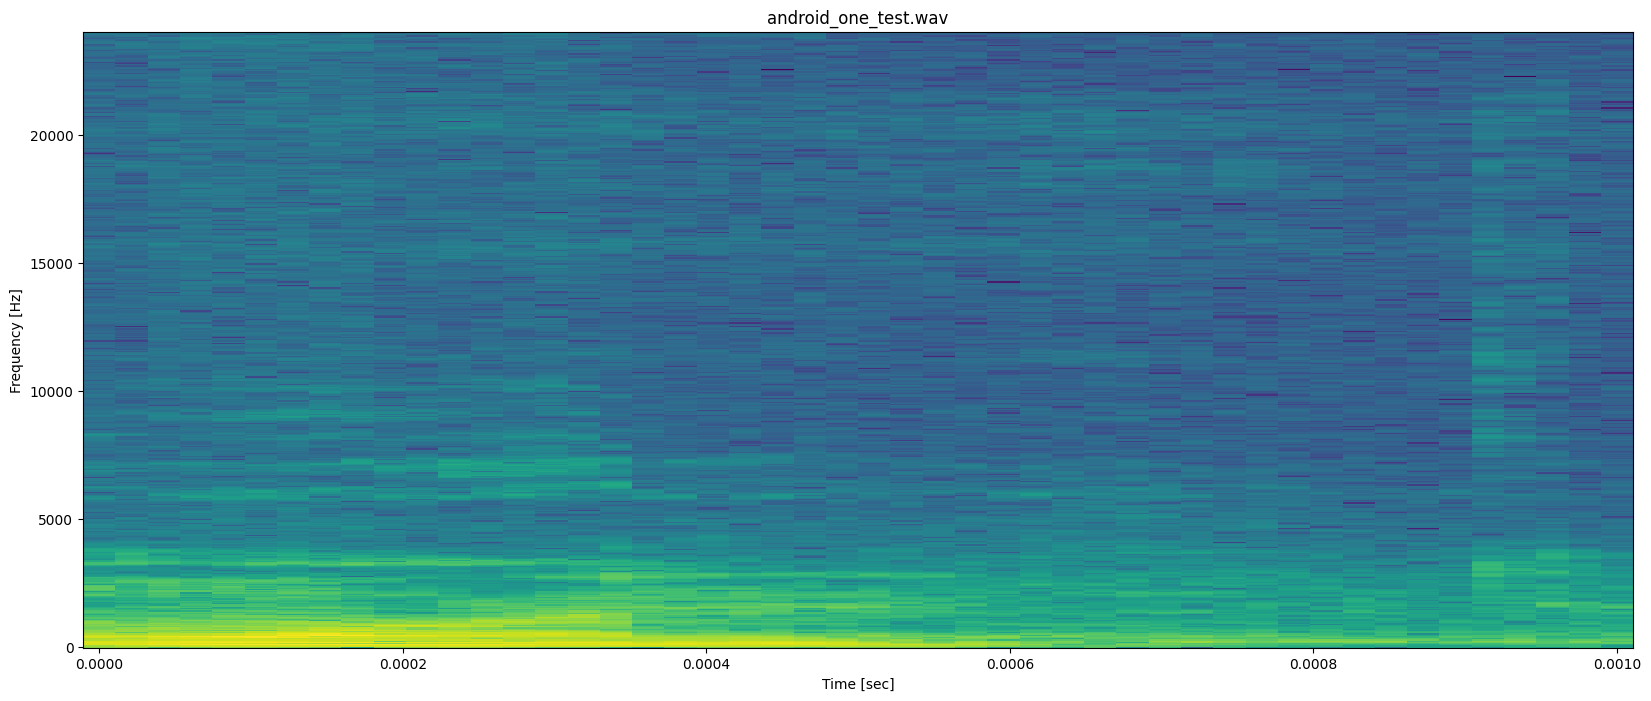

In [43]:
first_frame = np.argwhere(framesVoiced > 0)[0,0]
print(first_frame)
last_frame = (first_frame + NUM_COLS) if ((first_frame + NUM_COLS) < result.shape[1]) else result.shape[1]-1
# altering the STFT
segmented_result = np.zeros((NUM_ROWS, NUM_COLS))
for row in range(NUM_ROWS):
    for col in range(NUM_COLS):
        curr_frame = first_frame + col
        if curr_frame >= result.shape[1]:
            break
        segmented_result[row,col] = result[row, curr_frame]

# altering the data
segmented_data = data[first_frame*step:last_frame*step]

t_stft = np.linspace(0, NUM_COLS / Fs, NUM_COLS)
plt.figure(figsize=(20,8))
plt.pcolormesh(t_stft, f, segmented_result)
plt.title(song_file)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
Audio(segmented_data, rate=Fs)

Typically the most energy is found in words which employ a lower '-duh' frequency sound. This comes from letters such as D and B. Listening to the trimmed audio carefully, it is clear that the speaker pronounces the letter Z with a '-duh' sound which explains why that was the first frame where energy was detected. There is still some valuable data from the frames before as can be seen in the STFT spectrum so we will just constantly collect these few frames. 

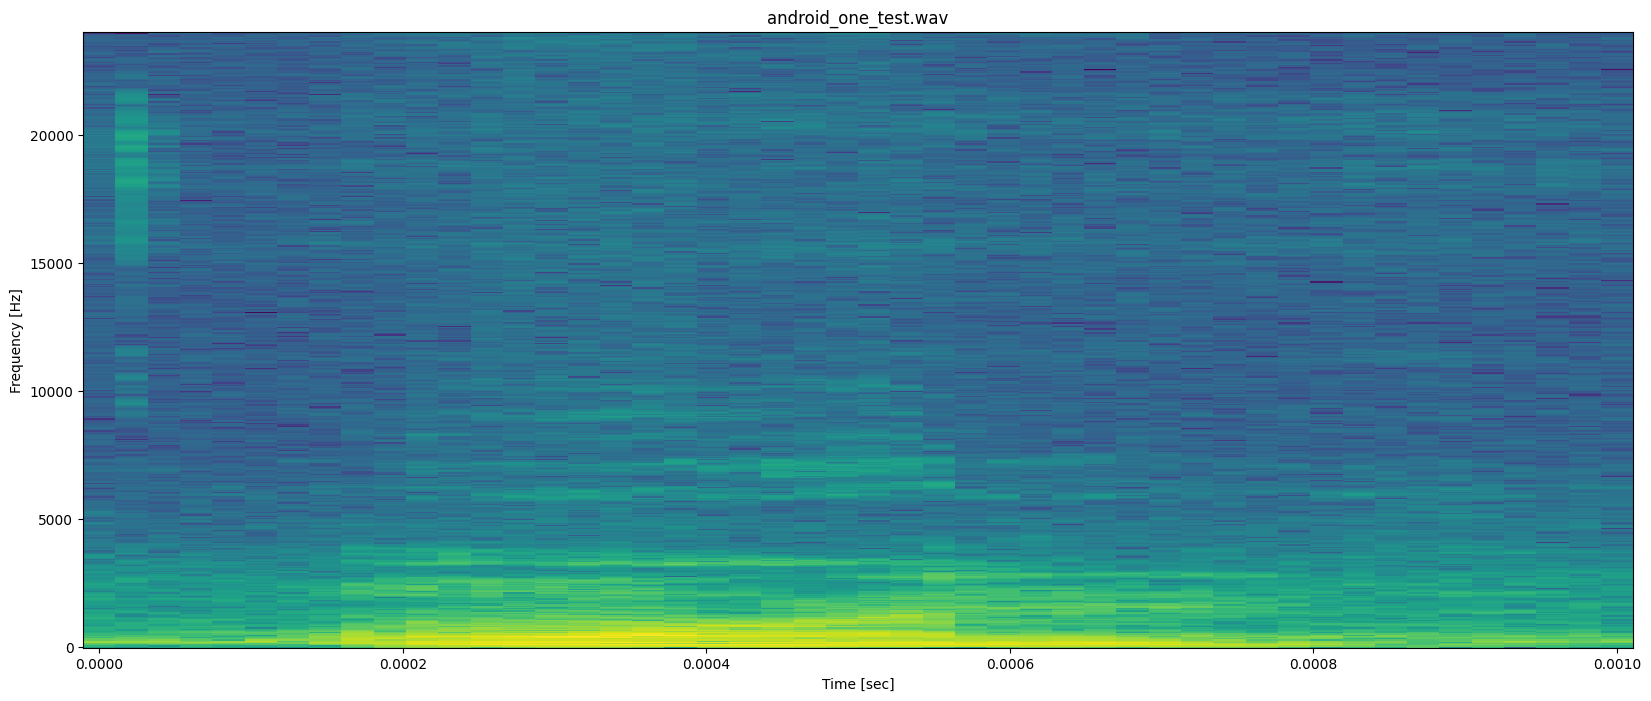

In [44]:
first_frame = first_frame - FRAME_SETBACK
last_frame = (first_frame + NUM_COLS) if ((first_frame + NUM_COLS) < result.shape[1]) else result.shape[1]-1
# altering the STFT
segmented_result = np.zeros((NUM_ROWS, NUM_COLS))
for row in range(NUM_ROWS):
    for col in range(NUM_COLS):
        curr_frame = first_frame + col
        if curr_frame >= result.shape[1]:
            break
        segmented_result[row,col] = result[row, curr_frame]

# altering the data
segmented_data = data[first_frame*step:last_frame*step]

t_stft = np.linspace(0, NUM_COLS / Fs, NUM_COLS)
plt.figure(figsize=(20,8))
plt.pcolormesh(t_stft, f, segmented_result)
plt.title(song_file)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
Audio(segmented_data, rate=Fs)

#### Saving Newly Trimmed Data

The code below just shows how to save the newly trimmed audio file and reloading the file is as before.

In [45]:
write("SimplePitchDetectionAudioOut.wav", rate = Fs, data=data[(first_frame-FRAME_SETBACK)*step:].astype(np.int16))
test_fs, test_data = read("SimplePitchDetectionAudioOut.wav")
Audio(test_data, rate=test_fs)

#### Error Checking

Below I am doing a check that performing this pitch detection on the entire AudioMNIST set doesn't create an error, otherwise additional cases will have to be thought through. The only potential case is where no pitch was detected, thus we cannot grab a 'first_frame'. In this scenario, it may suffice to not bother trimming the data and hope that the voiced content resides near the beginning of the audio data. 

In [46]:
# Testing to see if any errors are generated

for i in range(60):
    digit = i + 1
    if digit < 10:
        digit = '0'+str(digit)
    else:
        digit = str(digit)
    curr_audios = os.listdir(curr_dir + '/' + digit)
    for audio_name in curr_audios:

        Fs, data = read(curr_dir + '/' + digit + '/' + audio_name)
        num_samples = len(data)

        noverlap = int(FRAME_SIZE / 2)
        step = FRAME_SIZE - noverlap
        numFrames = ceil(num_samples / step)
        while ((numFrames - 1)*step + (FRAME_SIZE - 1) >= num_samples):
            numFrames -= 1

        # numFrames = int(len(data) / FRAME_SIZE)
        framesVoiced = np.zeros(numFrames)
        t = np.linspace(0, len(data)/Fs, numFrames)

        for i in range(numFrames):
            frame = data[i * step : (i + 1) * step]
            framesVoiced[i] = ece420ProcessFrame(frame.astype(float), 100e4)

        first_frame = np.argwhere(framesVoiced > 0)[0,0] # checking to see if this causes an error where no first_frame is detected
        first_frame = first_frame - FRAME_SETBACK if (first_frame > 0) else 0 # if including the setback results in a negative index, just make the first index 0

#### Data Trimming
This code below is only intended to trim my own voice files and save them to a folder

In [47]:
read_dir = os.getcwd() + '/' + 'raw_voice_files'
write_dir = os.getcwd() + '/' + 'trimmed_voice_files'

raw_file_titles = os.listdir(read_dir)
raw_file_titles.sort()
trimmed_file_data = []

label_counter = 0
for n in range(len(raw_file_titles)):
    raw_file = raw_file_titles[n]
    Fs, data = read(read_dir + '/' + raw_file)

    if (n % 60 == 0) and n != 0:
        label_counter += 1

    num_samples = len(data)
    # print("len of data: {}".format(num_samples))

    noverlap = int(FRAME_SIZE / 2)
    step = FRAME_SIZE - noverlap
    numFrames = ceil(num_samples / step)
    while ((numFrames - 1)*step + (FRAME_SIZE - 1) >= num_samples):
        numFrames -= 1

    framesVoiced = np.zeros(numFrames)
    # t = np.linspace(0, len(data)/Fs, numFrames)

    for i in range(numFrames):
        frame = data[i * step : (i + 1) * step]
        framesVoiced[i] = ece420ProcessFrame(frame.astype(float))

    first_frame = np.argwhere(framesVoiced > 0)[0,0]

    first_frame = first_frame - FRAME_SETBACK
    last_frame = (first_frame + NUM_COLS) if ((first_frame + NUM_COLS) < result.shape[1]) else result.shape[1]-1

    # altering the data
    segmented_data = data[first_frame*step:last_frame*step]
    trimmed_file_data.append((segmented_data, raw_file))
    # write("SimplePitchDetectionAudioOut.wav", rate = Fs, data=data[(first_frame-FRAME_SETBACK)*step:].astype(np.int16))
    write(write_dir + '/' + '{}_{}_data.wav'.format(label_counter, n%60), rate = Fs, data=segmented_data.astype(np.int16))

/tmp/ipykernel_382/3194114125.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = read(read_dir + '/' + raw_file)


In [48]:
# playing some of the files
Audio(trimmed_file_data[500][0], rate=Fs)